## TA Review 3, VaR and Rolling Risk Measures
### FINM 36700 - 2025

#### Midterm Tips and Tricks

1. Understand the Homework: The goal of the midterm is not to trick you, or ask you questions you have no idea how to answer. Instead, the midterm is solely based on your understanding of the material seen in the homework and in class. So, really make sure you understand what (a) my code is doing, (b) what the homework questions are asking, and (c) what the content we have covered in class is about.

2. Make a Template: I strongly suggest making a midterm Jupyter Notebook template. This template should already have your name, any helper functions you'll need, and any imports you'll need. This will save you valuable time when it comes time to take the midterm, since you won't need to worry at all about your coding environment.

3. Answer What is Asked: For a lot of the conceptual questions, you can achieve full-marks on them in 1-2 succint sentences. Really try to answer the question: if it's a True/False question, say either True or False, not "both". You don't need to write paragraphs for these questions. 

4. Low-Hanging Fruit: In contrast to some exams you might have taken before, the midterm does not necessarily get harder the further you progress into it. Therefore, you should aim to answer as many questions as possible, even if they are not in order. If you're stuck on a question, quickly move on to the next one and come back to it later. Don't think that because you're stuck on Q1, then Q3 will be even harder.

5. Avoid Vanilla Jupyter: I strongly suggest using either VSCode or PyCharm to take the midterm. They have much better support for autocompletion, debugging, extensions, etc. than regular Jupyter Notebooks.

#### Overview

Volatility, skewness, and kurtosis are all ways to measure risk. Another way to measure it is Value at Risk (VaR), it basically answers the question of "What is the most I can expect to lose on this investment over a given time period with a certain level of confidence?" 

Why do we care about it? Well, it lets us quantify our risk beyond just volatility, and the *big* reason is that regulators/clearing houses/banks care about this. So, it is very standard to be required to report VaR for portfolios.

#### Non-Parametric VaR

The easiest way to calculate VaR is "non-parametric VaR", this just looks at historical returns and finds the percentile of returns that correspond to the confidence level you want. 

So, if my return series is: `0.01, 0.02, -0.03, 0.04, -0.01`, and I want to get 20% VaR, the 20th percentile of this series is -0.03, so my 20% VaR is 3%.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

plt.style.use("bmh")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

df = pd.read_excel(
    "risk_etf_data.xlsx", sheet_name="total returns", index_col=0, parse_dates=True
)
df.head()

,SPY,VEA,UPRO,GLD,USO,FXE,BTC,HYG,IEF,TIP,SHV
Date,,,,,,,,,,,
2017-01-04,0.005949,0.012238,0.017834,0.003530,0.012238,0.009314,0.106233,0.005408,0.001145,0.002207,-0.000090
2017-01-05,-0.000794,0.008866,-0.003057,0.015515,0.010363,0.010896,-0.122410,-0.001488,0.006484,0.003434,-0.000091
2017-01-06,0.003578,-0.003995,0.011323,-0.007373,-0.001709,-0.006700,-0.109711,-0.000229,-0.004547,-0.004125,0.000272
2017-01-09,-0.003301,-0.002406,-0.009447,0.008233,-0.031678,0.003617,0.000695,-0.000230,0.003807,0.001587,0.000181
2017-01-10,0.000000,0.001072,-0.001648,0.004260,-0.021220,-0.001072,0.005373,0.000116,-0.000474,0.000792,-0.000091


In [2]:
df.quantile(0.05).to_frame("VaR(0.05)")

,VaR(0.05)
SPY,-0.017639
VEA,-0.015707
UPRO,-0.052788
GLD,-0.014410
USO,-0.035377
FXE,-0.007298
BTC,-0.062464
HYG,-0.007132
IEF,-0.006843
TIP,-0.005292


What is one issue with this method?

Well, suppose that I *know* my returns are i.i.d normal with variance $\sigma^2$, but, I only have 20 data points that are all less than 2 standard deviations away from the mean. Then, my non-parametric VaR will severely underestimate the true VaR, since I have only seen a small portion of the distribution (the middle part).

#### Parametric VaR

To get around this, we typically use some kind of parametric VaR, where we try to enforce some distribution/model on the returns and then use that to calculate VaR. The simplest way to do this is to assume returns are normally distributed, and therefore:

$$
r_i \sim N(\mu, \sigma^2)
$$

$$
VaR(\alpha) = \mu + \sigma \Phi^{-1}(\alpha)
$$

Where $\Phi^{-1}$ is the inverse CDF of the standard normal distribution. So if we wanted to get 5% VaR, we would get:
$$
VaR(0.05) = \mu + \sigma \Phi^{-1}(0.05) = \mu - 1.645\sigma
$$

Additionally, note that we can use the regular scaling of $\sqrt{t}$ to get VaR over longer time period. So if I had monthly returns and wanted to calculate 1-year VaR, I would do:
$$
VaR_{1 year}(0.05) = \sigma_{monthly}*\sqrt{12} * \Phi^{-1}(0.05)
$$
Assuming 0 mean returns.

In [3]:
# Calculate parametric VaR assuming normality.
mean = df.mean()
std = df.std()
var_95 = stats.norm.ppf(0.05, loc=mean, scale=std)
pd.DataFrame(var_95, index=df.columns, columns=["Parametric VaR(0.05)"])

,Parametric VaR(0.05)
SPY,-0.018925
VEA,-0.017754
UPRO,-0.056995
GLD,-0.014281
USO,-0.039793
FXE,-0.007571
BTC,-0.069211
HYG,-0.008811
IEF,-0.007077
TIP,-0.006127


#### Beyond VaR

Suppose my return time series looks like this: `0.01, 0.01,...,-1`

So I let's say 20 of my returns are 1%, and then I have one return that is -100%. What is the 5% VaR? 1%! So by just looking at the 5th quantile, I am missing the fact that the tails of my distribution might be very fat and extend well beyond the 5th percentile (ie. my one -100% return).

To deal with this, we can use something called Conditional VaR (CVaR), or Expected Shortfall (ES). This is the expected loss *conditional* on the loss being worse than the VaR level. So, in the example above, my VaR is 1%, but my CVaR is -49.5% (average of -100% and 1%).

More formally:
$$
CVaR(\alpha) = E[r | r < VaR(\alpha)]
$$

And again, we could calculate this non-parametrically, or if we use the normal distribution, we can get a closed form solution:
$$
CVaR(\alpha) = \mu - \sigma \frac{\phi(\Phi^{-1}(\alpha))}{\alpha}
$$

In [4]:
cvar_nonparametric = df[df <= df.quantile(0.05)].mean()
cvar_assuming_normality = mean - std * stats.norm.pdf(stats.norm.ppf(0.05)) / 0.05
pd.DataFrame(
    {
        "CVaR(0.05)": cvar_nonparametric,
        "CVaR assuming normality": cvar_assuming_normality,
    }
)

,CVaR(0.05),CVaR assuming normality
SPY,-0.028965,-0.023887
VEA,-0.025588,-0.022362
UPRO,-0.087000,-0.071866
GLD,-0.020447,-0.018039
USO,-0.059263,-0.049952
FXE,-0.009614,-0.009511
BTC,-0.098037,-0.087592
HYG,-0.012710,-0.011096
IEF,-0.009483,-0.008888
TIP,-0.008595,-0.007711


What problem do both of these methods (normal, non-parametric) have? The way that we've run them so far, they use *all* of the data. That means that my volatility estimate (and therefore VaR estimate) is not updating to reflect changes in volatility. To see this:

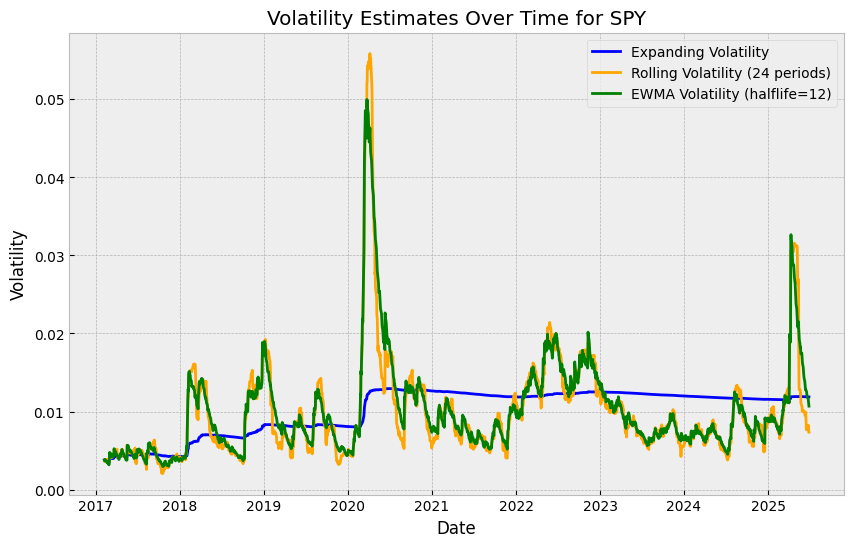

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

expanding_vol = df.expanding(min_periods=24).std()
rolling_vol = df.rolling(window=24).std()
ewm_vol = df.ewm(halflife=12, min_periods=24).std()

ax.plot(
    expanding_vol.index,
    expanding_vol["SPY"],
    label="Expanding Volatility",
    color="blue",
)
ax.plot(
    rolling_vol.index,
    rolling_vol["SPY"],
    label="Rolling Volatility (24 periods)",
    color="orange",
)
ax.plot(
    ewm_vol.index, ewm_vol["SPY"], label="EWMA Volatility (halflife=12)", color="green"
)
ax.set_title("Volatility Estimates Over Time for SPY")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()
plt.show()

Obviously, volatility should be high in 2020, but note how the expanding VaR estimate barely budges. The reason for this is that if we're using all the data up to that point, the influence of each new data point is very small (and becomes smaller). 

$$
\sigma^2_t = \frac{1}{t - 1}\sum_{i=1}^t (r_i - \bar{r})^2
$$

One way to fix this would be to use a rolling window, where we use the last N days of data to estimate volatility:

$$
\sigma^2_t = \frac{1}{N - 1}\sum_{i=t-N+1}^t (r_i - \bar{r})^2
$$

What is one issue with this method?

Well, if we have one period of very high volatility, and then we're back to low volatility, our rolling window will have a gap up, and then a gap down, which makes it very weird.

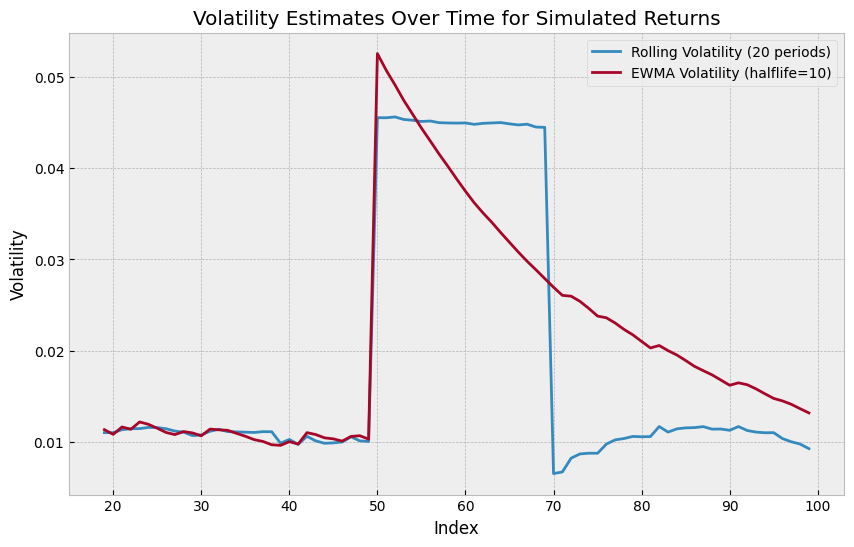

In [6]:
# Make normal random variable with 0.01 volatility
rv = np.random.normal(loc=0, scale=0.01, size=100)

# Make a single point be a big negative return
rv[50] = -0.2

rv_series = pd.Series(rv)
rv_volatility = rv_series.rolling(window=20).std()
rv_vol_ewm = rv_series.ewm(halflife=10, min_periods=20).std()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rv_volatility, label="Rolling Volatility (20 periods)")
ax.plot(rv_vol_ewm, label="EWMA Volatility (halflife=10)")
ax.set_title("Volatility Estimates Over Time for Simulated Returns")
ax.set_xlabel("Index")
ax.set_ylabel("Volatility")
ax.legend()
plt.show()

And for EWMA volatility, we have 2 (equivalent) formulas.

First, we can specify the $\lambda$, which is the decay factor (between 0 and 1), and then we have:
$$
\sigma^2_t = \sum_{i=0}^{t-1} \lambda^{i} r_{t-i}^2
$$
Or, we can specify the half-life, which is the amount of time it takes for the weight to decay by half. Then, we can calculate $\lambda$ as:
$$
\lambda = \left(\frac{1}{2}\right)^{1/h}
$$
I always prefer to use half-life since it is more intuitive.

Volatility estimates are a whole can of worms which I will be skip over, but some food for thought here is that both of these methods are bad because of the "gap" totally screwing up an anotherwise normal volatility estimate. Also, we are using "close-to-close" volatility, which is not great. As an example, let's say my stock closed at 100 yesterday, and today it opened at 50, went up to 150, and then closed at 100. The close-to-close volatility is 0%, but the intraday volatility is huge.

Some alternatives are:
- Using higher frequency data (5-min returns, etc.) to estimate volatility (and then annualize it)
- Using range-based measures (Garman-Klass, Parkinson, Rogers-Satchel)

Euan Sinclair's book (Volatility Trading) has a very good discussion of this.

What kind of trading strategy depends entirely on having extremely good realized volatility estimates?

There is also the whole world of GARCH models, which I'll talk about at the end if we have time since they aren't covered in the midterm.

In general, though, the core idea here is that you want to be updating your model dynamically. It does introduce more hyperparameters (window size, decay half life, etc.) but it is well worth it.

#### Evaluation

How do we know if our VaR model is any good? Well, the easiest way is to just calculate the "hit rate", which is the percent of times that the return is worse than my (current) VaR estimate. If my model is good, then this should be very close to the alpha level I'm using, so if I'm using 5% VaR, then about 5% of the time my return should be worse than my VaR estimate.

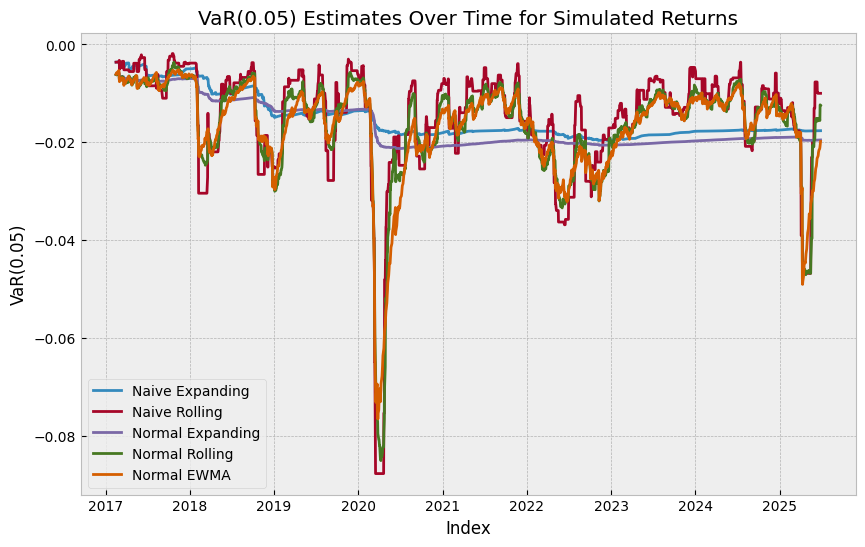

In [7]:
# Compute naive, expanding VaR estimates.
spy = df["SPY"]

naive_var = spy.expanding(min_periods=30).quantile(0.05)
rolling_var = spy.rolling(window=30).quantile(0.05)

# Compute normal VaR estimates using expanding, rolling, and EWMA volatilities (assume 0 mean return).
expanding_std = spy.expanding(min_periods=30).std()
rolling_std = spy.rolling(window=30).std()
ewm_std = spy.ewm(halflife=15, min_periods=30).std()
normal_var_expanding = pd.Series(
    stats.norm.ppf(0.05, loc=0, scale=expanding_std), index=spy.index
)
normal_var_rolling = pd.Series(
    stats.norm.ppf(0.05, loc=0, scale=rolling_std), index=spy.index
)
normal_var_ewm = pd.Series(stats.norm.ppf(0.05, loc=0, scale=ewm_std), index=spy.index)

# Plot all VaR estimates.
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(naive_var, label="Naive Expanding")
ax.plot(rolling_var, label="Naive Rolling")
ax.plot(normal_var_expanding, label="Normal Expanding")
ax.plot(normal_var_rolling, label="Normal Rolling")
ax.plot(normal_var_ewm, label="Normal EWMA")
ax.set_title("VaR(0.05) Estimates Over Time for Simulated Returns")
ax.set_xlabel("Index")
ax.set_ylabel("VaR(0.05)")
ax.legend()
plt.show()

In [8]:
# Calculate the hit ratio for each method.
def hit_ratio(returns, var_estimates):
    hits = returns.shift(1).dropna() < var_estimates[1:]
    return hits.sum() / len(hits)


hit_ratios = {
    "Naive Expanding": hit_ratio(spy, naive_var),
    "Naive Rolling": hit_ratio(spy, rolling_var),
    "Normal Expanding": hit_ratio(spy, normal_var_expanding),
    "Normal Rolling": hit_ratio(spy, normal_var_rolling),
    "Normal EWMA": hit_ratio(spy, normal_var_ewm),
}
pd.DataFrame.from_dict(hit_ratios, orient="index", columns=["Hit Ratio for SPY"])

,Hit Ratio for SPY
Naive Expanding,0.062881
Naive Rolling,0.069920
Normal Expanding,0.054435
Normal Rolling,0.053965
Normal EWMA,0.049273


#### Conclusion on VaR

Generally, parametric VaR is better than non-parametric VaR, particularly when we're using a rolling/EWMA volatility estimate.

We can evaluate our VaR model by looking at the hit rate.

Our parametric VaR will typically only be as good as our forward looking volatility estimates.

Thoughts? Comments? Questions? Feelings?

#### Run Through of the Class Exercise


In [9]:
spx = pd.read_excel(
    "spx_returns_weekly.xlsx", sheet_name="s&p500 rets", index_col=0, parse_dates=True
)[["AAPL", "META", "NVDA", "TSLA"]]
spx.head()

,AAPL,META,NVDA,TSLA
date,,,,
2015-01-09,0.024514,-0.009055,-0.009315,-0.057685
2015-01-16,-0.053745,-0.032931,0.000836,-0.065760
2015-01-23,0.065950,0.035255,0.037578,0.042575
2015-01-30,0.036997,-0.024669,-0.072636,0.011476
2015-02-06,0.019114,-0.018967,0.062269,0.067589


#### 1. Full Sample Vol/VaR/CVaR

In [10]:
stds = spx.std() * np.sqrt(52)
var = spx.quantile(0.05)
cvar = spx[spx <= var].mean()
summary_risk = pd.DataFrame(
    {"Annualized Volatility": stds, "VaR(0.05)": var, "CVaR(0.05)": cvar}
)
summary_risk

,Annualized Volatility,VaR(0.05),CVaR(0.05)
AAPL,0.276629,-0.056366,-0.083125
META,0.351336,-0.070012,-0.103196
NVDA,0.463283,-0.086853,-0.116455
TSLA,0.586431,-0.117397,-0.147814


#### 1.2 Equally Weighted Portfolio

In [11]:
# Calculate weighted portfolio returns
weights = np.array([0.25, 0.25, 0.25, 0.25])
portfolio_rets = spx.dot(weights)

std_port = portfolio_rets.std() * np.sqrt(52)
var_port = portfolio_rets.quantile(0.05)
cvar_port = portfolio_rets[portfolio_rets <= var_port].mean()
pd.DataFrame(
    {
        "Annualized Volatility": [std_port],
        "VaR(0.05)": [var_port],
        "CVaR(0.05)": [cvar_port],
    },
    index=["Equally Weighted Portfolio"],
)

,Annualized Volatility,VaR(0.05),CVaR(0.05)
Equally Weighted Portfolio,0.315543,-0.06195,-0.084992


#### 1.3 Dropping Most Volatile Asset (TSLA)

In [12]:
weights = np.array([0.25, 0.25, 0.25, 0.0])

portfolio_rets_no_tsla = spx.dot(weights)
std_port = portfolio_rets_no_tsla.std() * np.sqrt(52)
var_port = portfolio_rets_no_tsla.quantile(0.05)
cvar_port = portfolio_rets_no_tsla[portfolio_rets_no_tsla <= var_port].mean()
pd.DataFrame(
    {
        "Annualized Volatility": [std_port],
        "VaR(0.05)": [var_port],
        "CVaR(0.05)": [cvar_port],
    },
    index=["Dropping TSLA"],
)

,Annualized Volatility,VaR(0.05),CVaR(0.05)
Dropping TSLA,0.218365,-0.042463,-0.060531


#### 2.1 Volatility

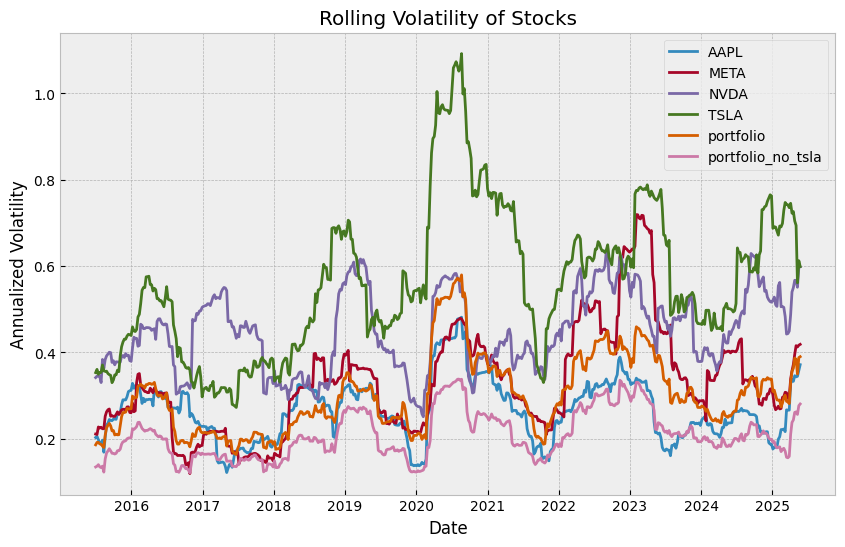

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
spx["portfolio"] = portfolio_rets
spx["portfolio_no_tsla"] = portfolio_rets_no_tsla

rolling_vol = spx.rolling(window=26, min_periods=26).std() * np.sqrt(52)

ax.plot(rolling_vol, label=rolling_vol.columns)
ax.set_title("Rolling Volatility of Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Annualized Volatility")
ax.legend()
plt.show()

#### 2.2 Assume Mean is 0, and Calculate VaR/CVaR

In [14]:
last_rolling_vol = rolling_vol.iloc[-1]

var_95 = stats.norm.ppf(0.05) * last_rolling_vol / np.sqrt(52)
cvar_95 = (
    -(last_rolling_vol / np.sqrt(52)) * stats.norm.pdf(stats.norm.ppf(0.05)) / 0.05
)

print("Conditional (using last rolling volatility)")
display(
    pd.DataFrame(
        {
            "Annualized Volatility": last_rolling_vol,
            "VaR(0.05) assuming normality": var_95,
            "CVaR(0.05) assuming normality": cvar_95,
        }
    )
)
print("Unconditional (empirical CDF)")
display(
    pd.DataFrame(
        {
            "Annualized Volatility": (full_std := spx.std() * np.sqrt(52)),
            "VaR(0.05)": (var_tmp := spx.quantile(0.05)),
            "CVaR(0.05)": spx[spx <= var_tmp].mean(),
        }
    )
)

Conditional (using last rolling volatility)


,Annualized Volatility,VaR(0.05) assuming normality,CVaR(0.05) assuming normality
AAPL,0.371224,-0.084676,-0.106187
META,0.418310,-0.095417,-0.119656
NVDA,0.598249,-0.136461,-0.171127
TSLA,0.598597,-0.136540,-0.171227
portfolio,0.389750,-0.088902,-0.111487
portfolio_no_tsla,0.280156,-0.063904,-0.080138


Unconditional (empirical CDF)


,Annualized Volatility,VaR(0.05),CVaR(0.05)
AAPL,0.276629,-0.056366,-0.083125
META,0.351336,-0.070012,-0.103196
NVDA,0.463283,-0.086853,-0.116455
TSLA,0.586431,-0.117397,-0.147814
portfolio,0.315543,-0.061950,-0.084992
portfolio_no_tsla,0.218365,-0.042463,-0.060531


#### 2.3 Backtesting the Hit Rate

In [15]:
time_series_normal_var = rolling_vol * stats.norm.ppf(0.05) / np.sqrt(52)
time_series_normal_cvar = (
    -(rolling_vol / np.sqrt(52)) * stats.norm.pdf(stats.norm.ppf(0.05)) / 0.05
)

time_series_normal_var = time_series_normal_var.shift(1).dropna()
time_series_normal_cvar = time_series_normal_cvar.shift(1).dropna()

spx_subset = spx.loc[time_series_normal_var.index]
hits_var = spx_subset < time_series_normal_var
hits_cvar = spx_subset < time_series_normal_cvar

(hits_var.sum() / len(hits_var)).to_frame("Hit Ratio VaR(0.05)")

,Hit Ratio VaR(0.05)
AAPL,0.052326
META,0.044574
NVDA,0.044574
TSLA,0.052326
portfolio,0.042636
portfolio_no_tsla,0.038760


#### Extras(?): Probability of Underperformance

Assume the following setup, we have lognormal prices, and therefore log-returns are normal. If we assume that returns are i.i.d normal with mean $\mu$ and variance $\sigma^2$, then the probability of underperforming a threshold $r^*$ over a time period $T$ directly comes from a z-score.

\begin{align*}
\mathbb{P}(R_t \leq r^*) &= \mathbb{P}\left(\sum_{i=1}^t r_i \leq r^*\right) \\
&= \mathbb{P}\left(\frac{\sum_{i=1}^t r_i - t\mu}{\sigma\sqrt{t}} \leq \frac{r^* - t\mu}{\sigma\sqrt{t}}\right) \\
&= \Phi\left(\frac{r^* - t\mu}{\sigma\sqrt{t}}\right)\\
&= \Phi\left(- \sqrt{t} \frac{\mu}{\sigma}\right)\\
\end{align*}

This follows directly from the fact that the sum of normal random variables is also normal. So, if we have $1,\dots,t$ forward looking periods (eg. we have monthly data and want to look 12 months ahead), then each monthly log-return distributed as $N(\mu, \sigma^2)$, and therefore the sum of these returns is distributed as $N(t\mu, t\sigma^2)$.

#### Extras: GARCH

Given that for all of these parametric VaR models, we are plugging in some kind of volatility estimate. Note that if we assume mean zero returns, then our volatility estimate is *exactly* the same as the variance of our residuals (returns). Additionally, recall that we want to have a dynamically updating volatility estimate. GARCH naturally fits into this framework, since it is *exactly* a model for the variance of residuals that have time-varying volatility (heteroskedasticity).

From Data Analysis and Regression:

$$
\sigma_{t}^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

Where $\epsilon_{t-1}$ is the residual, and $\sigma_{t-1}^2$ is the previous period's variance estimate. So, assuming zero mean returns:

$$
\sigma_{t}^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

So we can use GARCH to get a dynamically updating volatility estimate, and then plug that into our parametric VaR formula.

In [16]:
import arch

garch_model = arch.arch_model(spy, mean="Zero", vol="Garch", p=1, q=1, rescale=False)
garch_fit = garch_model.fit(disp="off")

conditional_vol = garch_fit.conditional_volatility
garch_var = pd.Series(
    stats.norm.ppf(0.05, loc=0, scale=conditional_vol), index=spy.index
)

hit_ratio(spy, garch_var)

np.float64(0.024870952604411075)

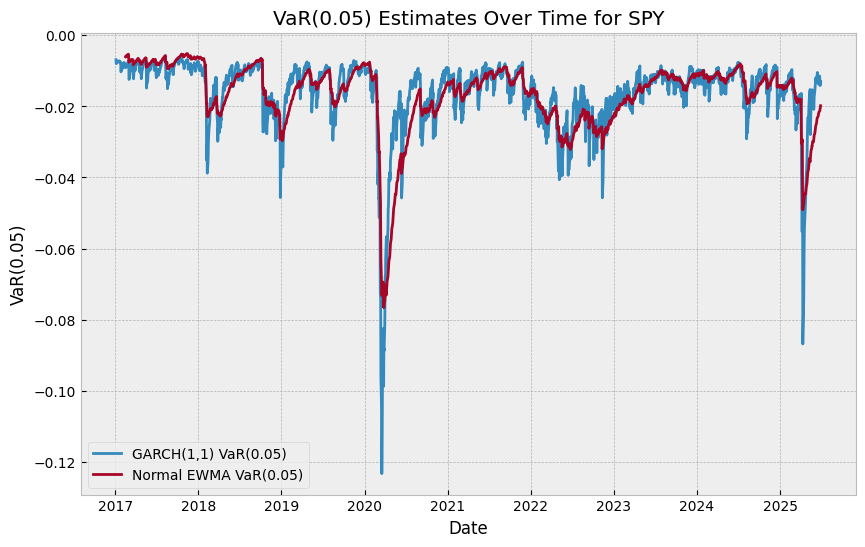

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(garch_var, label="GARCH(1,1) VaR(0.05)")
ax.plot(normal_var_ewm, label="Normal EWMA VaR(0.05)")
ax.set_title("VaR(0.05) Estimates Over Time for SPY")
ax.set_xlabel("Date")
ax.set_ylabel("VaR(0.05)")
ax.legend()
plt.show()

Not particularly good! But with some tweaking we can potentially improve it.

Another thing we could do aside from the volatility estimate, is the actual return distribution profile. So specifically, perhaps returns are *not* normally distributed.

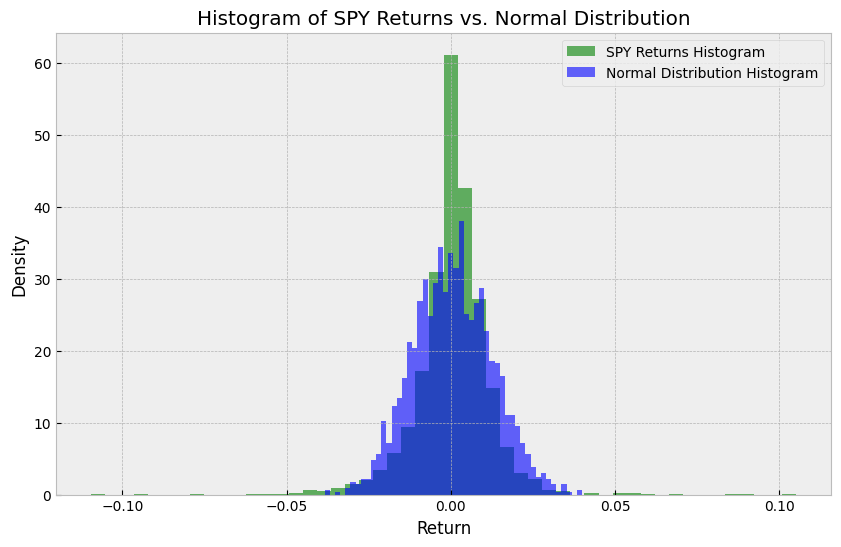

In [18]:
# Plot SPY histogram vs. normal histogram with same data points
fig, ax = plt.subplots(figsize=(10, 6))
mean, scale = spy.mean(), spy.std()
normal_x = np.random.normal(loc=mean, scale=scale, size=len(spy))

ax.hist(spy, bins=50, density=True, alpha=0.6, color="g", label="SPY Returns Histogram")
ax.hist(
    normal_x,
    bins=50,
    density=True,
    alpha=0.6,
    color="b",
    label="Normal Distribution Histogram",
)
ax.set_title("Histogram of SPY Returns vs. Normal Distribution")
ax.set_xlabel("Return")
ax.set_ylabel("Density")
ax.legend()
plt.show()

Therefore, we could do something like kernel density estimation (KDE) to "smooth" our return distribution and have a quasi-parametric VaR model.

$$
\hat{f}(x) = \frac{1}{nh}\sum_{i=1}^n K\left(\frac{x - x_i}{h}\right)
$$

Where we can think of each $K$ as a bump (typically Gaussian), and some smoothing parameter $h$ that controls how wide the bumps are. So basically treat each data point as a little Gaussian, and then add them all up to get a smooth distribution.

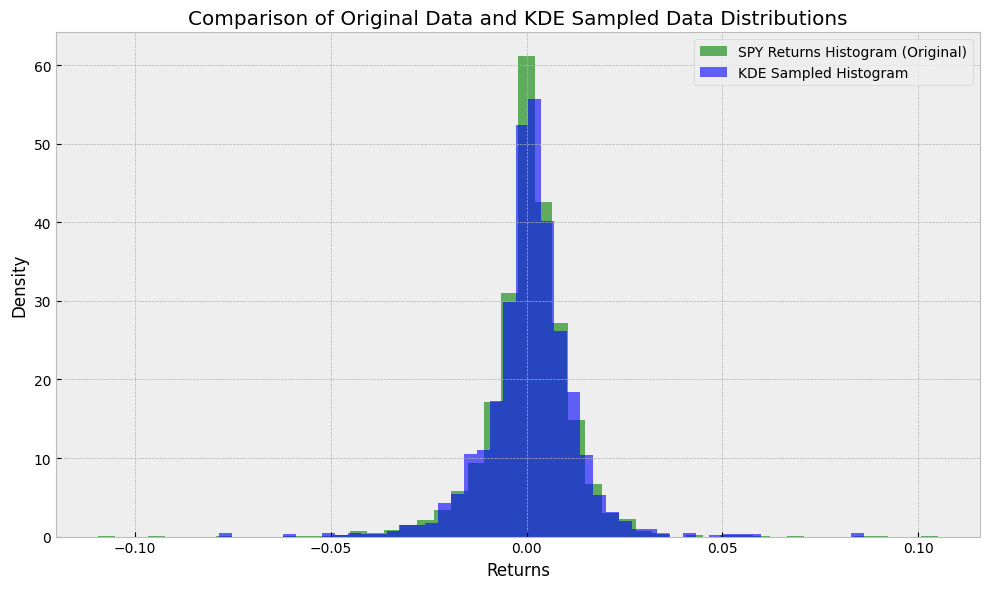

In [19]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel="gaussian", bandwidth=0.001).fit(spy.values.reshape(-1, 1))

new_samples = kde.sample(n_samples=len(spy))

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(
    spy,
    bins=50,
    alpha=0.6,
    color="g",
    density=True,
    label="SPY Returns Histogram (Original)",
)
ax.hist(
    new_samples.flatten(),
    bins=50,
    alpha=0.6,
    color="b",
    density=True,
    label="KDE Sampled Histogram",
)

ax.set_title("Comparison of Original Data and KDE Sampled Data Distributions")
ax.set_xlabel("Returns")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()

Now you can imagine potentially combining this with our previous volatility estimates. 

Some other food for thought:
1. If we're calculating the VaR for a *portfolio*, how do we account for correlations between assets?
2. How can we account for negative returns typically being autocorrelated? 
3. Any more complex dynamics?

Well, one easy way to do this would be to use a Monte Carlo simulation, where we can simulate a large number of return paths based on our volatility estimates, and then use the empirical distribution to calculate VaR. Simulation also would allow us to easily account for correlations between assets, path dynamics, etc. 

100%|██████████| 10000/10000 [00:02<00:00, 4018.67it/s]


Monte Carlo 1-Year VaR: -14.20%


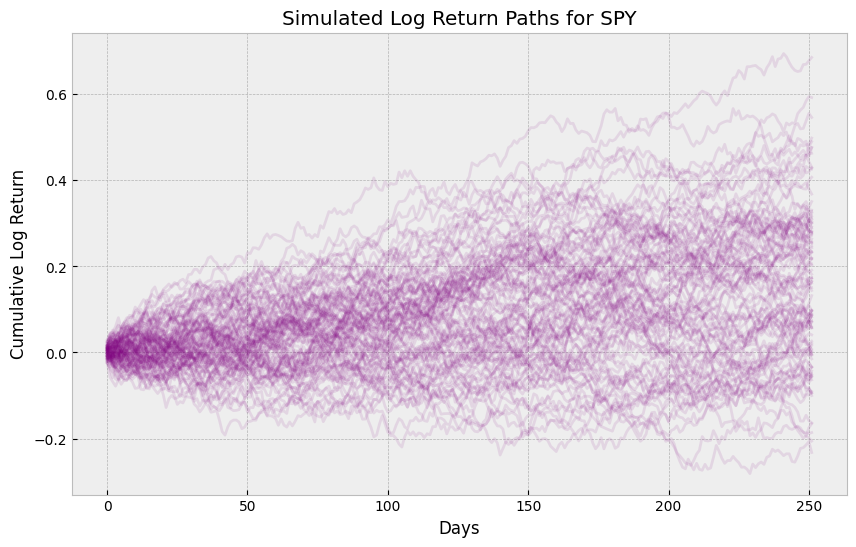

In [20]:
from tqdm import tqdm

mu = spy.mean()
sigma = spy.std()

N_PATHS = 10_000
N_DAYS_FORECAST = 252
CORR_NEG_RETURNS = 0.0

simulated_log_returns = np.zeros((N_DAYS_FORECAST, N_PATHS))
last_log_return = spy.values[-1]

for i in tqdm(range(N_PATHS)):
    current_log_return = last_log_return

    for t in range(N_DAYS_FORECAST):
        z = np.random.normal(0, 1)
        unconditional_return = mu + sigma * z

        if current_log_return < 0:
            new_return = (CORR_NEG_RETURNS * current_log_return) + (
                (1 - CORR_NEG_RETURNS) * unconditional_return
            )
        else:
            new_return = unconditional_return

        simulated_log_returns[t, i] = new_return
        current_log_return = new_return

simulated_simple_returns = np.exp(simulated_log_returns) - 1
cumulative_returns = np.prod(1 + simulated_simple_returns, axis=0) - 1

VaR_level = 0.05
VaR_return = np.percentile(cumulative_returns, VaR_level * 100)
VaR_loss = -VaR_return

print(f"Monte Carlo 1-Year VaR: {VaR_return * 100:.2f}%")

plt.figure(figsize=(10, 6))
for i in range(min(N_PATHS, 100)):
    plt.plot(np.cumsum(simulated_log_returns[:, i]), alpha=0.1, color="purple")

plt.title("Simulated Log Return Paths for SPY")
plt.xlabel("Days")
plt.ylabel("Cumulative Log Return")
plt.show()

Lets suppose I want to add some negative return autocorrelation, so let's say that if my previous return is negative, then my next return is 5% correlated to the previous return. 

100%|██████████| 10000/10000 [00:02<00:00, 4195.31it/s]


Monte Carlo 1-Year VaR: -19.16%


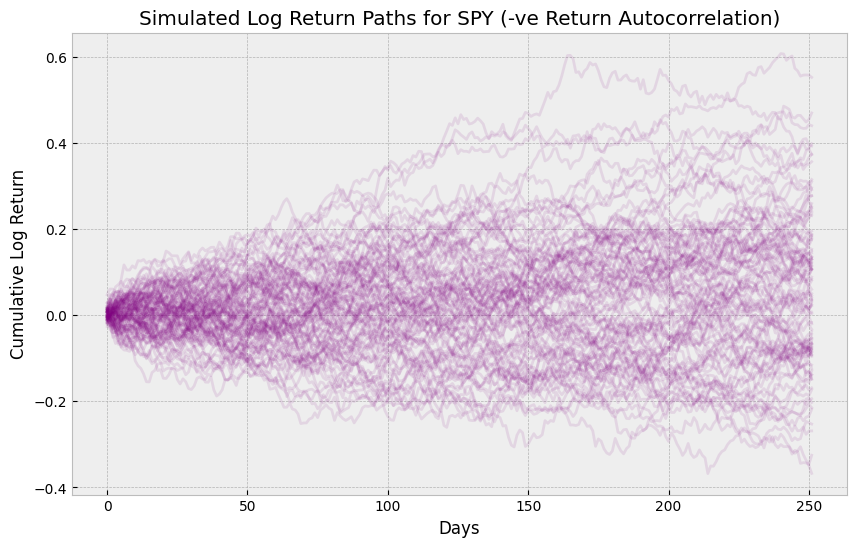

In [21]:
CORR_NEG_RETURNS = 0.05

simulated_log_returns = np.zeros((N_DAYS_FORECAST, N_PATHS))
last_log_return = spy.values[-1]

for i in tqdm(range(N_PATHS)):
    current_log_return = last_log_return

    for t in range(N_DAYS_FORECAST):
        z = np.random.normal(0, 1)
        unconditional_return = mu + sigma * z

        if current_log_return < 0:
            new_return = (CORR_NEG_RETURNS * current_log_return) + (
                (1 - CORR_NEG_RETURNS) * unconditional_return
            )
        else:
            new_return = unconditional_return

        simulated_log_returns[t, i] = new_return
        current_log_return = new_return

simulated_simple_returns = np.exp(simulated_log_returns) - 1
cumulative_returns = np.prod(1 + simulated_simple_returns, axis=0) - 1

VaR_level = 0.05
VaR_return = np.percentile(cumulative_returns, VaR_level * 100)
VaR_loss = -VaR_return

print(f"Monte Carlo 1-Year VaR: {VaR_return * 100:.2f}%")

plt.figure(figsize=(10, 6))
for i in range(min(N_PATHS, 100)):
    plt.plot(np.cumsum(simulated_log_returns[:, i]), alpha=0.1, color="purple")

plt.title("Simulated Log Return Paths for SPY (-ve Return Autocorrelation)")
plt.xlabel("Days")
plt.ylabel("Cumulative Log Return")
plt.show()